In [1]:
import os
import sys
os.chdir("../../../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from src.tourism.mtsmodel import VARPipeline
from statsmodels.tsa.vector_ar.vecm import *
from src.tourism.scaler import ScaledLogitScaler
from collections import Counter
from src.tourism.data import CovidDataLoader, TrendsDataLoader
from src.tourism.ts_eval import calculate_evaluation
from src.tourism.ts_utils import cointegration_test

/Users/czhang/miniforge3/envs/bayes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2024-01-09 18:54:20 - prophet.plot:39 - ERROR] Importing plotly failed. Interactive plots will not work.


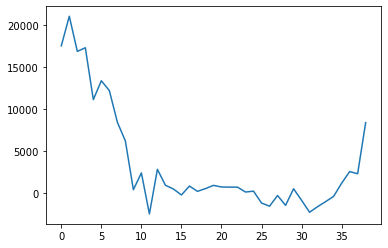

In [5]:
mts = VARPipeline(country="samoa",
                  y_var=["total", "seats_arrivals_intl"],
                  exog_var=["covid", "stringency_index", "samoa_travel"],
                  training_ratio=0.95)
mts.read_and_merge()
mts.determine_analysis_method()
mts.fit()
mts.get_fittedvalues()


False
3 1


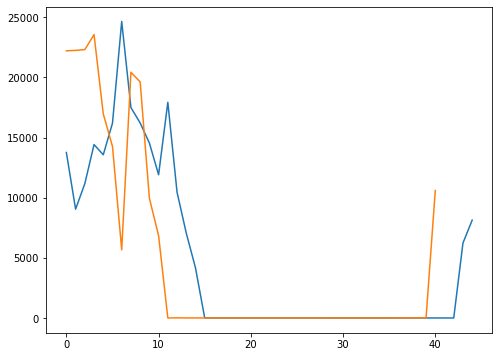

In [12]:
transform = True
mts = VARPipeline(country="samoa",
                  y_var=["total", "seats_arrivals_intl"],
                  exog_var=["covid", "stringency_index", "samoa_travel"],
                  training_ratio=0.95)
mts.read_and_merge()


raw = mts.data
df = raw[raw.date >= "2019-01-01"].reset_index(drop=True).dropna()
print(mts.test_stationarity(df, ["total", "seats_arrivals_intl"]))

scaler = ScaledLogitScaler()
scaler.fit(raw[["total", "seats_arrivals_intl"]])

if transform:
    train_data = scaler.transform(raw[["total", "seats_arrivals_intl"]]).dropna()
else:
    train_data = raw[["total", "seats_arrivals_intl"]].dropna()
index = train_data.index
exog_data = raw[["covid", "stringency_index", "samoa_travel"]].iloc[index]

selected_orders = select_order(train_data, exog=exog_data, maxlags=5)

# Extract values and count occurrences
order_counts = Counter(selected_orders.selected_orders.values())
selected_order = order_counts.most_common(1)[0][0]

johansen_test = coint_johansen(train_data,
                               det_order=0,
                               k_ar_diff=selected_order)

# Determine the number of cointegrating relationships
coint_rank = sum(
    johansen_test.lr1
    > johansen_test.cvt[:, 0])  # Number of relations with p-value < 0.05
print(selected_order, coint_rank)

mod = VECM(train_data,
           k_ar_diff=selected_order,
           coint_rank=coint_rank,
           exog=exog_data)
res = mod.fit()

covid = CovidDataLoader("palau").read_covid_data()
trend = TrendsDataLoader("palau").read_trends_data()
exog_df = covid.merge(trend[["date", "palau travel"]])
exog_df.columns = [col.replace(" ", "_") for col in exog_df.columns]
exog_df = exog_df.iloc[len(train_data) - 12:]

forecast = res.predict(steps=len(exog_df)-1, exog_fc=exog_df.iloc[:-1, [2, 1,3]])
if transform:
    forecast = scaler.inverse_transform(forecast)
    fitted_values = scaler.inverse_transform(res.fittedvalues)
else:
    fitted_values = res.fittedvalues
    
    
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(df['total'].values)
plt.plot(fitted_values[:, 0])

In [15]:
from pmdarima.model_selection import SlidingWindowForecastCV, RollingForecastCV


def cross_validate(endog_data, exog_data, maximum_order, criteria):

    cv = RollingForecastCV(step=1, h=6, initial=20)
    cv_generator = cv.split(endog_data)
    cv_slides = [*cv_generator]

    errors = []
    for order in range(1, maximum_order + 1):
        orders = []
        for train_idx, test_idx in cv_slides:
            train = endog_data.iloc[train_idx]
            train_exog = exog_data.iloc[train_idx]
            test = endog_data.iloc[test_idx]
            test_exog = exog_data.iloc[test_idx]

            model = VECM(train, k_ar_diff=order, coint_rank=1, exog=train_exog)
            model_fitted = model.fit()

            forecast = model_fitted.predict(steps=len(test), exog_fc=test_exog)
            error = calculate_evaluation(test, forecast)
            orders.append(error[criteria])
        errors.append(orders)

    return errors

In [16]:
errors = cross_validate(train_data, exog_data, 5, "SMAPE")
for order, i in zip(range(1, len(errors)), errors):
    print(order, np.mean(i))

1 46.04619538103084
2 45.643843377296164
3 51.7153894114202
4 57.36896472995799
